In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from dl1_data_handler.reader import DL1DataReaderSTAGE1, DL1DataReaderDL1DH
import h5py
import os
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics


def unison_shuffled_copies(a, b):
    """shuffle proton/gamma images and proton/gamma labels the same way"""
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p] , b[p]

2022-01-06 00:43:38.082873: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
#load training images from npy data on woody:
#gamma_images = np.load("/home/woody/caph/mppi109h/gamma10000.npy")
#proton_images = np.load("/home/woody/caph/mppi109h/proton10000.npy")


#load .h5 gamma events from dmitry and convert to npy for training
filename = "/home/saturn/caph/mpp228/CTA_data/Prod5_GRID/Prod5_square_images/gamma-diffuse_50000_images.h5"
with h5py.File(filename, "r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]

    # Get the data
    data = list(f[a_group_key])
    print(f["image"].shape)
    gamma_images = np.array(f["image"])
    
    hillas = list(f["hillas_intensity"]) #hillas intensity for every image
    print(len(hillas))
    
print(gamma_images.shape)


#load .h5 proton events from dmitry and convert to npy for training
filename2 = "/home/saturn/caph/mpp228/CTA_data/Prod5_GRID/Prod5_square_images/proton_50000_images.h5"
with h5py.File(filename2, "r") as f2:
    # List all groups
    print("Keys: %s" % f2.keys())
    a_group_key = list(f2.keys())[0]

    # Get the data
    data2 = list(f2[a_group_key])
    print(f2["image"].shape)
    proton_images = np.array(f2["image"])
    
print(proton_images.shape)

Keys: <KeysViewHDF5 ['hillas_intensity', 'hillas_kurtosis', 'hillas_length', 'hillas_phi', 'hillas_psi', 'hillas_r', 'hillas_skewness', 'hillas_width', 'hillas_x', 'hillas_y', 'image', 'image_mask', 'morphology_num_large_islands', 'morphology_num_medium_islands', 'morphology_num_pixels', 'true_alt', 'true_az', 'true_energy']>
(50000, 110, 110)
50000
(50000, 110, 110)
Keys: <KeysViewHDF5 ['hillas_intensity', 'hillas_kurtosis', 'hillas_length', 'hillas_phi', 'hillas_psi', 'hillas_r', 'hillas_skewness', 'hillas_width', 'hillas_x', 'hillas_y', 'image', 'image_mask', 'morphology_num_large_islands', 'morphology_num_medium_islands', 'morphology_num_pixels', 'true_alt', 'true_az', 'true_energy']>
(50000, 110, 110)
(50000, 110, 110)


In [3]:
#prepare for training and testing
images_whole = np.concatenate((gamma_images, proton_images), dtype = "float32")
proton_label = np.ones(50000) #protons have label 1
gamma_label = np.zeros(50000) #gammas have label 0
labels_whole = np.concatenate((proton_label, gamma_label))

print(images_whole.shape) #50000 proton and 50000 gamma images stacked
print(labels_whole.shape) #corresponding 100000 labels stacked

#shuffle training data
images_whole, labels = unison_shuffled_copies(images_whole, labels_whole) #does function work on axis 0 for images?
"""
#split traings set and test set
test_images = images_whole[95000:,:,:]
test_labels = labels[95000:]
images = images_whole[:95000,:,:]
labels = labels[:95000]
"""
#make train/test split
train_images, test_images, train_labels, test_labels = train_test_split(images_whole, labels, test_size=0.05, random_state=42)

#prepare for neural network input
train_images = np.expand_dims(train_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)
print(test_labels.shape)
print(test_images.shape)
print(train_labels.shape)
print(train_images.shape)

(100000, 110, 110)
(100000,)
(5000,)
(5000, 110, 110, 1)
(95000,)
(95000, 110, 110, 1)


/tmp/ipykernel_25150/1046725255.py:10: DeprecationWarning: This function is deprecated. Please call randint(0, 9000 + 1) instead
  rand = np.random.random_integers(0,9000)


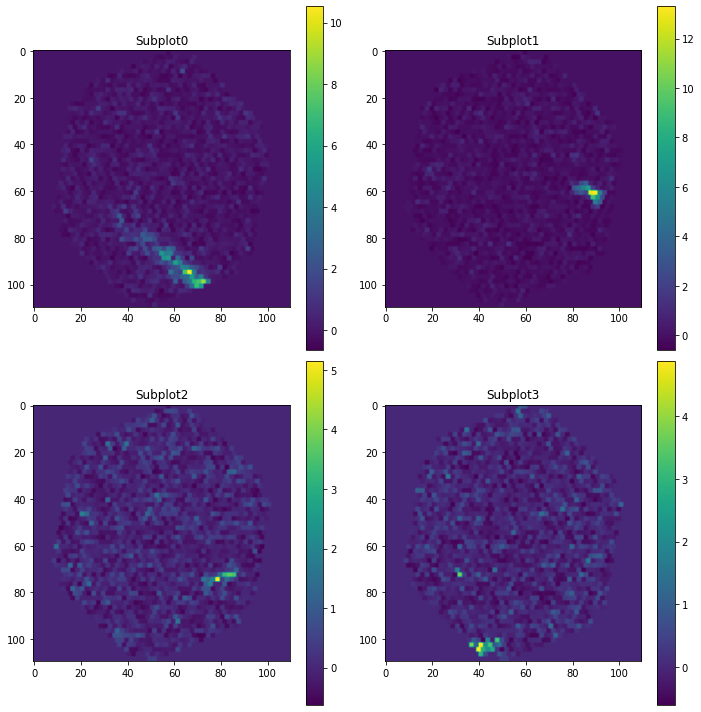

In [4]:
#print random examples of gamma events to see how the data looks like
width=5
height=5
rows = 2
cols = 2
axes=[]
fig=plt.figure(figsize=(10, 10))

for a in range(rows*cols):
    rand = np.random.random_integers(0,9000)
    b = gamma_images[a+rand,:,:]
    axes.append( fig.add_subplot(rows, cols, a+1) )
    subplot_title=("Subplot"+str(a))
    axes[-1].set_title(subplot_title)  
    plt.imshow(b)
    plt.colorbar()
fig.tight_layout()    
plt.show()

/tmp/ipykernel_25150/1050591248.py:10: DeprecationWarning: This function is deprecated. Please call randint(0, 9000 + 1) instead
  rand = np.random.random_integers(0,9000)


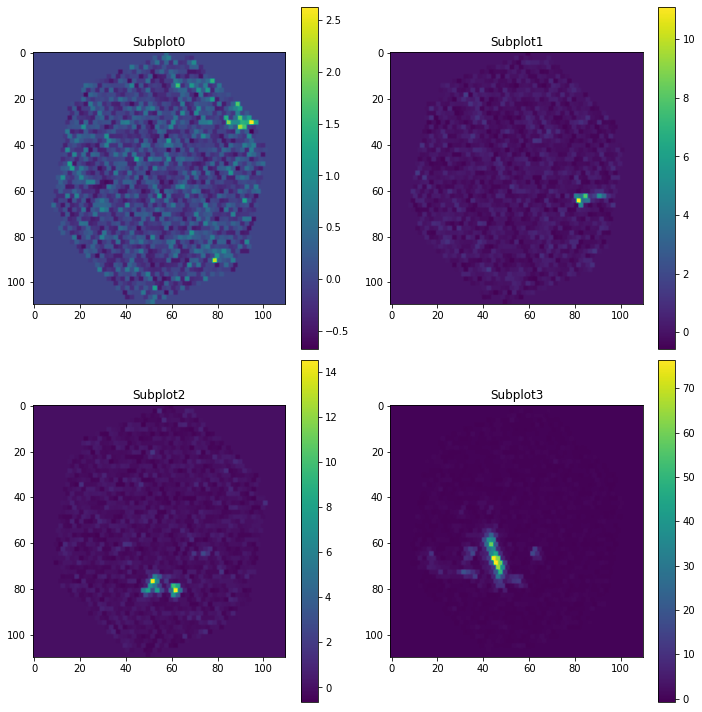

In [5]:
#print random examples of proton events to see how the data looks like
width=5
height=5
rows = 2
cols = 2
axes=[]
fig=plt.figure(figsize=(10, 10))

for a in range(rows*cols):
    rand = np.random.random_integers(0,9000)
    b = proton_images[a+rand,:,:]
    axes.append( fig.add_subplot(rows, cols, a+1) )
    subplot_title=("Subplot"+str(a))
    axes[-1].set_title(subplot_title)  
    plt.imshow(b)
    plt.colorbar()
fig.tight_layout()    
plt.show()

In [20]:

#define/crate neural network with layers
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(110, 110,1)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=2e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=2e-5)),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(2, activation='softmax')
])

#compile neural network
model.compile(optimizer='adam',
              loss= tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

#train neural network
history = model.fit(train_images, train_labels, validation_split = 0.1, epochs=20)

#save model
#model.save("/home/woody/caph/mppi109h/keras-model-cnn")

#print(model.summary()) #show structure of neural ntwork

Epoch 1/14
2672/2672 [==============================] - 10s 4ms/step - loss: 0.7381 - accuracy: 0.4988 - val_loss: 0.6945 - val_accuracy: 0.5151
Epoch 2/14
2672/2672 [==============================] - 9s 3ms/step - loss: 0.6963 - accuracy: 0.5089 - val_loss: 0.6954 - val_accuracy: 0.5176
Epoch 3/14
2672/2672 [==============================] - 9s 3ms/step - loss: 0.6959 - accuracy: 0.5289 - val_loss: 0.6966 - val_accuracy: 0.5247
Epoch 4/14
2672/2672 [==============================] - 9s 3ms/step - loss: 0.6970 - accuracy: 0.5356 - val_loss: 0.6986 - val_accuracy: 0.5175
Epoch 5/14
2672/2672 [==============================] - 9s 3ms/step - loss: 0.7021 - accuracy: 0.5343 - val_loss: 0.7013 - val_accuracy: 0.5205
Epoch 6/14
2672/2672 [==============================] - 9s 3ms/step - loss: 0.6966 - accuracy: 0.5436 - val_loss: 0.7030 - val_accuracy: 0.5222
Epoch 7/14
2672/2672 [==============================] - 9s 3ms/step - loss: 0.6980 - accuracy: 0.5528 - val_loss: 0.7046 - val_accuracy

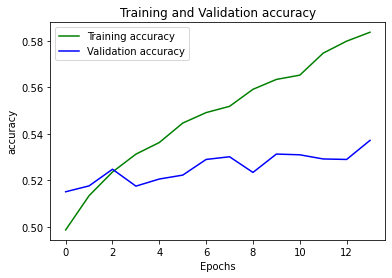

157/157 - 0s - loss: 0.7176 - accuracy: 0.5224

Test accuracy: 0.5224000215530396


/home/woody/caph/mpp228/apps/anaconda3/envs/tfgpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


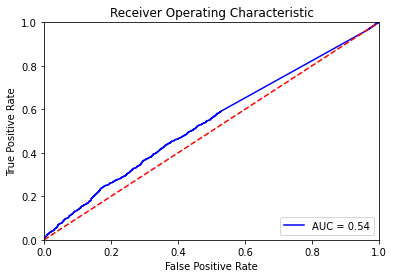

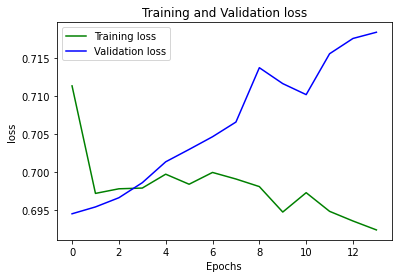

In [21]:
#Show results of training:

#show accuracy by epochs
print(history) 
plt.plot(history.history['accuracy'], 'g', label='Training accuracy')
plt.plot(history.history['val_accuracy'], 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

#check accuracy with testimages
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print('\nTest accuracy:', test_acc)



# calculate the fpr and tpr for all thresholds of the classification
probs = model.predict_proba(test_images)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(test_labels, preds)
roc_auc = metrics.auc(fpr, tpr)

# show ROC plot
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#show accuracy by epochs
print(history) 
plt.plot(history.history['loss'], 'g', label='Training loss')
plt.plot(history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()



In [8]:

"""
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters = 16, kernel_size = 2, padding='same', activation='relu', input_shape = (110,110,1), kernel_regularizer=tf.keras.regularizers.l2(l2=2e-4)),
    tf.keras.layers.SpatialDropout2D(0.3),
    tf.keras.layers.Conv2D(filters = 10, kernel_size = 2, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=2e-4)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=2e-4)),
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=2e-4)),
    tf.keras.layers.Dense(2, activation='softmax')
])
"""

""""
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(110, 110,1)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu', ),
    tf.keras.layers.Dense(2, activation='softmax')
])
"""

'"\nmodel = tf.keras.Sequential([\n    tf.keras.layers.Flatten(input_shape=(110, 110,1)),\n    tf.keras.layers.Dropout(0.5),\n    tf.keras.layers.Dense(128, activation=\'relu\', ),\n    tf.keras.layers.Dense(2, activation=\'softmax\')\n])\n'

In [9]:
# example derived from /home/woody/caph/mpp228/ML/CTA/dl1-data-handler_stage1/notebooks/dl1reading_stage1.ipynb

def descend_obj(obj, sep='\t', res_str=''):
    """
    Iterate through groups in a HDF5 file and prints the groups and 
    datasets names and datasets attributes
    """
    if type(obj) in [h5py._hl.group.Group, h5py._hl.files.File]:
        for key in obj.keys():
            try:
                res_str += '%s-%s: %s\n' % (sep, key, obj[key])
            except:
                res_str += '%s-%s: %s\n' % (sep, key, 'problem:(')
            res_str = descend_obj(obj[key], sep=sep+sep, res_str=res_str)
    elif type(obj)==h5py._hl.dataset.Dataset:
        for key in obj.attrs.keys():
            try:
                res_str += '%s+%s: %s\n' % (sep+sep, key, obj.attrs[key])
            except:
                res_str += '%s+%s: %s\n' % (sep+sep, key, 'problem here')
    return res_str

mode = 'mlgrid_gamma-diffuse' #'mlgrid_proton', 'mlgrid_gamma-diffuse'
if mode == 'mlgrid_proton':
    folder = '/home/saturn/caph/mpp228/CTA_data/Prod5_GRID/'
    folder += 'Prod5_Paranal_AdvancedBaseline_NSB1x_proton_North_20deg_ctapipe_v0.10.5_DL1/'
    fn0 = 'proton_20deg_0deg_run14656___cta-prod5-paranal_desert-2147m-Paranal-dark_merged.DL1.h5'
elif mode == 'mlgrid_gamma-diffuse':
    folder = '/home/saturn/caph/mpp228/CTA_data/Prod5_GRID/'
    folder += 'Prod5_Paranal_AdvancedBaseline_NSB1x_gamma-diffuse_North_20deg_ctapipe_v0.10.5_DL1/'
    fn0 = 'gamma_20deg_0deg_run5996___cta-prod5-paranal_desert-2147m-Paranal-dark_cone10_merged.DL1.h5'
fn = folder + fn0


test = DL1DataReaderSTAGE1(["/home/saturn/caph/mpp228/CTA_data/Prod5_GRID/Prod5_square_images/proton_50000_images.h5"],
                                 mode='mono',
                                 #example_identifiers_file="./examples.h5",
                                 selected_telescope_types=["LST_LST_LSTCam"],
                                 selected_telescope_ids = {"LST_LST_LSTCam": [1]},
                                 image_channels = ['image', 'peak_time', 'image_mask'],
                                 parameter_list = ['hillas_intensity', 'hillas_x'],
                                 event_info = ["true_energy", "true_alt", "true_az"])



#test_path = fn2reader("/home/saturn/caph/mpp228/CTA_data/Prod5_GRID/Prod5_Paranal_AdvancedBaseline_NSB1x_gamma-diffuse_North_20deg_ctapipe_v0.10.5_DL1")
print(test)

ImportError: Numba needs NumPy 1.20 or less